In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import matplotlib.cm as cm

import scipy
import scipy.cluster.hierarchy as sch
import time

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabaz_score

from IPython.core.display import display, HTML
from datetime import datetime, timedelta

pd.set_option('display.float_format', '{:.5g}'.format)

def getKey(item):
    return item[0]


def addAtt(data,key,value):
    data[key] = value
    return data

folder='datosSalidaSimulacion'
indexFile='_1D_2_1_198_234_datos0823'

# Carga de datos

In [2]:
dataOut = pd.read_csv(folder+'/dataOut'+indexFile+'.csv',
                 delimiter='\t',
                 decimal='.',
                 header=None)

dataOut.index = pd.to_datetime(dataOut[0])
del dataOut[0]

dfMeans = pd.read_csv(folder+'/dataOutMeans'+indexFile+'.csv',
                 delimiter='\t',
                 decimal='.',
                 header=None)
dfMeans.index = pd.to_datetime(dfMeans[0])
del dfMeans[0]

dataOut['m1']=dfMeans[1]
dataOut['m2']=dfMeans[2]
dataOut['fos']=dfMeans[3]

dataOut = dataOut[dataOut['fos'].notnull()]

In [3]:
orderList = pd.read_csv(folder+'/orders'+indexFile+'.csv',
                 delimiter='\t',
                 decimal='.',
                 header=None)


orderList.index = pd.to_datetime(orderList[0])
del orderList[0]

orderList = orderList[orderList[2] != 'CHANGE_DAY']
print(orderList.head(2))
print(orderList.tail(2))

                        1           2  3    4
0                                            
2019-07-19 03:00:00 62.59   BUY_ORDER  0 2000
2019-07-19 08:15:00 63.09  SELL_ORDER 10 2010
                        1           2   3      4
0                                               
2019-07-19 21:30:00  62.5   BUY_ORDER   0 2006.6
2019-07-19 23:45:00 62.87  SELL_ORDER 7.4   2014


In [4]:
orderList

1           2    3      4
0                                                
2019-07-19 03:00:00 62.59   BUY_ORDER    0   2000
2019-07-19 08:15:00 63.09  SELL_ORDER   10   2010
2019-07-19 08:30:00 63.02  SELL_ORDER    0   2010
2019-07-19 13:15:00 62.89   BUY_ORDER  2.6 2012.6
2019-07-19 13:30:00 62.96   BUY_ORDER    0 2012.6
2019-07-19 15:15:00 62.77  SELL_ORDER -3.8 2008.8
2019-07-19 15:30:00 62.66  SELL_ORDER    0 2008.8
2019-07-19 21:15:00 62.77   BUY_ORDER -2.2 2006.6
2019-07-19 21:30:00  62.5   BUY_ORDER    0 2006.6
2019-07-19 23:45:00 62.87  SELL_ORDER  7.4   2014

# Precios en tiempo

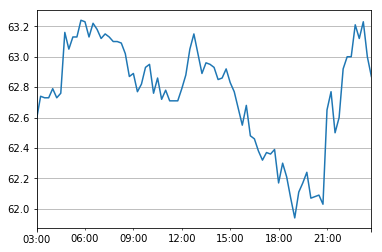

In [5]:
plt.figure()
dataOut[1].plot()
plt.grid()
plt.xlabel('')

plt.show()

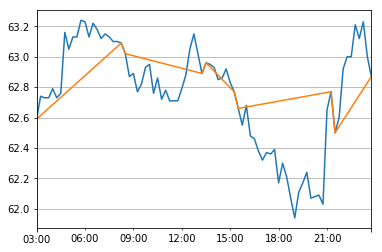

In [6]:
plt.figure()
dataOut[1].plot()
orderList[1].plot()
plt.grid()

plt.xlabel('')
plt.show()

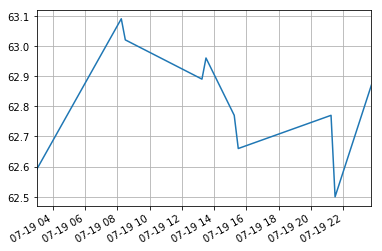

In [7]:
plt.figure()
orderList[1].plot()
plt.grid()
plt.xlabel('')
plt.show()

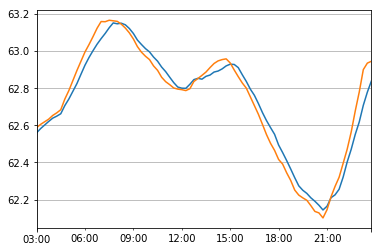

In [8]:
plt.figure()
dataOut['m1'].plot()
dataOut['m2'].plot()
plt.grid()
plt.xlabel('')
plt.show()

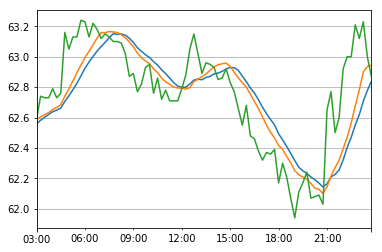

In [9]:
plt.figure()
dataOut['m1'].plot()
dataOut['m2'].plot()
dataOut[1].plot()
plt.grid()
plt.xlabel('')
plt.show()

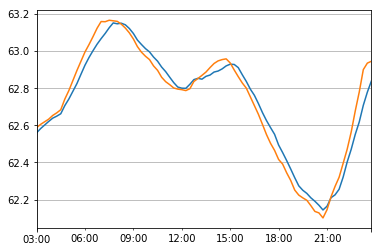

In [10]:

plt.figure()
dataOut['m1'].plot()
dataOut['m2'].plot()
#orderList[1].plot()
plt.grid()
plt.xlabel('')
plt.show()

# Precios por intervalo

In [11]:
df = dataOut.copy()
of = orderList.copy()
df.columns = ['price','m1', 'm2','fos']
of.columns = ['priceOrder', 'order', 'return', 'investment']

newData = pd.concat([df,of], axis=1, join_axes=[df.index])
newData['index']=1
newData['index']=newData['index'].cumsum()-1
newData['m1_m2'] = newData['m1']-newData['m2']


In [12]:
newDataNoNan = newData[newData['order'].notnull() ]


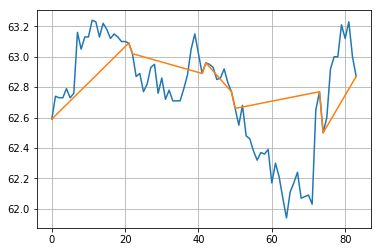

In [13]:
plt.figure()
df = newData[['index','price']]
plt.plot(df.values.T[0],df.values.T[1])
df = newDataNoNan[['index','price']]
plt.plot(df.values.T[0],df.values.T[1])
plt.grid()
plt.xlabel('')


plt.show()

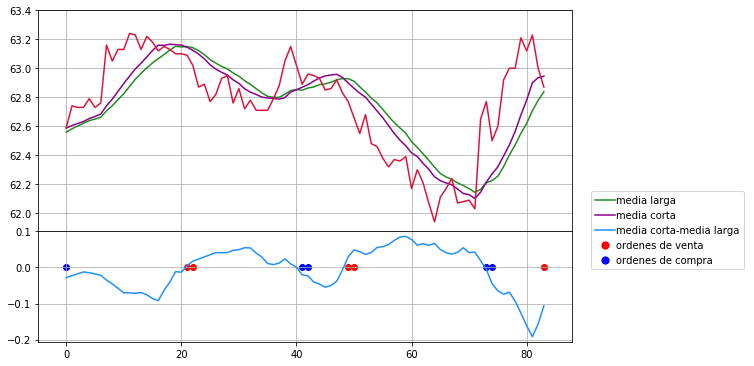

In [14]:
f, axarr = plt.subplots(2,1, figsize=(8,5))

axarr[0] = plt.subplot2grid((3,1), (0,0), rowspan=2)


df = newData[['index','m1']]
m1p = axarr[0].plot(df.values.T[0],df.values.T[1], c='forestgreen')[0]
df = newData[['index','m2']]
m2p = axarr[0].plot(df.values.T[0],df.values.T[1], c='darkmagenta')[0]

df = newData[['index','price']]
priceVal = axarr[0].plot(df.values.T[0],df.values.T[1], c='crimson')[0]

axarr[0].grid()

axarr[1] = plt.subplot2grid((3,1), (2,0), sharex=axarr[0])

df = newDataNoNan[['index','m1','order']]
for i,p,o in zip(df.values.T[0],df.values.T[1],df.values.T[2]):
    if 'SELL_ORDER' == o:
        sellOp = axarr[1].scatter([i],[0],c='red')
    elif 'BUY_ORDER' == o:
        buyOp = axarr[1].scatter([i],[0],c='blue')
        
df = newData[['index','m1_m2']]
m1_m2p = axarr[1].plot(df.values.T[0],df.values.T[1], c='dodgerblue')[0]
        
        
axarr[1].grid()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
f.subplots_adjust(hspace=0)

leg = plt.figlegend(
    [m1p, m2p, m1_m2p, sellOp, buyOp], 
    ['media larga','media corta','media corta-media larga','ordenes de venta','ordenes de compra'], 
    loc=1,
    bbox_to_anchor=(1.3, 0.5),
    handletextpad=0.1,
    markerscale=1.2,
    markerfirst = True)


for ax in axarr[:1]:
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_yticks(ax.get_yticks()[1:]) 

plt.savefig('figGenetic/exp'+indexFile+'.png', bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show()


In [15]:
#newData.to_csv('datosFinalSim/dataSim'+indexFile+'.csv', sep='\t')
#newDataNoNan.to_csv('datosFinalSim/dataOrdersSim'+indexFile+'.csv', sep='\t')

In [16]:
dataToSave = dataOut.copy()
del dataToSave['m1']
del dataToSave['m2']
del dataToSave['fos']
dataToSave.to_csv('datosParaSimulacion_MTCDocker/data.csv', sep=';',header=None)
dataToSave.head(2)

1
0                        
2019-07-19 03:00:00 62.59
2019-07-19 03:15:00 62.74